# Project Category Identification NLP Project <a id='Data Overview'></a>

## Table of Contents <a id='2.1_Contents'></a>
* [0. Background](#0)
* [1. Data Import - Building Dataset](#1)
* [2. Target Location Selection](#2)
* [3. Data Understanding](#3)
    * [3.1 Missing Values](#3.1)
    * [3.2 Meter Type Observation](#3.2)
    * [3.3 Building Area Observation](#3.3)
    * [3.4 Building Category Observation](#3.4)
    * [3.5 Building Energy Use Intensity](#3.5)
    * [3.6 Other Building Parameters](#3.6)
* [4.0 Save Data](#4.0)

## 0. Background

I built a web scrapping tool that scraps biding and tendering information from public sectors in Ontario. The public sectors includes regions such as York Region, Peel Region, Halton Region, and cities such as City of Mississauga.

The intend of the project is to use DATA to tell a story about the Competitiveness of the public sector. The collected information are used to conduct the following analysis:

* **Public Sector Market Understanding**: an overview of the public sector markets (services, construction, and goods), how the market changes over time.

* **Competitive Information**: an overview of the performance of private companies in different public sectors. What is their wining rate comparing with their competitors. The private companies includes construction companies such as Maple Reinders Constructors Ltd. and Kenaidan Contracting Ltd., consulting companies such WSP Canada Inc., Hatch Ltd., and good supplying companies.

* **Competitiveness by Category** Different private companies in the public sectors have overlapping skill sets in the public sectors, they may also specialize a niche that company leaders and strategist may not be aware off. The tool intends to use DATA to show competitiveness of each companies in different sectors such as consulting in water & wastewater, construction in civil engineering works, etc.

The collected information includes project names and a generic category information. In order to understand "Competitiveness by Category", the original "generic category" needs to further broken down into detailed categories. There are almost 10k project collected, it is not practical to provide a detailed category to each of the project,. Further more, as more projects be collected, manual tagging the category is timing consuming.

Therefore, Natural Language Processing (NLP) is used to do the category task for current projects and any future projects.

## 0.1 Import Libraries

In [81]:
import pandas as pd
import numpy as np
import datacleaning as datacleaning
import string
import re

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

from sklearn.feature_extraction.text import CountVectorizer



## 0.2 Import Original Dataset

In [82]:
path = "../NaturalLanguageProcessing/DataUpdate.csv"
df = pd.read_csv(path)
df.drop_duplicates(inplace=True)

## 1. Data Wrangling

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7246 entries, 0 to 7245
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          7246 non-null   int64 
 1   client_name         7246 non-null   object
 2   project_name        7246 non-null   object
 3   Category            2591 non-null   object
 4   bid_classification  7246 non-null   object
 5   bid_type            7246 non-null   object
 6   bid_ID              7246 non-null   object
 7   awarded_date        7246 non-null   object
 8   awarded_year        7246 non-null   int64 
 9   company_name        7246 non-null   object
dtypes: int64(2), object(8)
memory usage: 622.7+ KB


In [84]:
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,client_name,project_name,Category,bid_classification,bid_type,bid_ID,awarded_date,awarded_year,company_name
0,Brant County,"1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...",Producer/Supplier,Goods,RFQ,OPS-RFQ-20-07,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
1,Brant County,1 (One) Seven (7) Passenger Mini-Van,Producer/Supplier,Goods,RFQ,OPS-RFQ-20-04,2021-03-26 0:00,2020,Oxford Dodge Chrysler (1992) LTD
2,Brant County,1 (One) Seven (7) Passenger Van / Wagon,Producer/Supplier,Goods,RFQ,OPS-RFQ-20-10,2021-03-26 0:00,2020,East Court Ford Lincoln Oxford Dodge Chr...
3,Brant County,1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck,Producer/Supplier,Goods,RFQ,OPS-RFQ-20-08,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
4,Brant County,1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck,Producer/Supplier,Goods,RFQ,OPS-RFQ-20-09,2021-03-26 0:00,2020,East Court Ford Lincoln Finch Auto Group...


## 1.1 Data Exploration

### 1.1.1 Data Exploration - client_name

In [85]:
client_list = df.client_name.unique().tolist()
len(client_list)

19

In [86]:
client_list

['Brant County',
 'City Of Peterborough',
 'City of Barrie',
 'City of Brantford',
 'City of Guelph',
 'City of Hamilton',
 'City of Kawartha Lakes',
 'City of London',
 'City of Orillia',
 'Dufferin County',
 'Durham Region',
 'Haldimand County',
 'Halton Region',
 'Niagara Region',
 'Peel Region',
 'Peterborough County',
 'Simcoe County',
 'Waterloo Region',
 'York Region']

<AxesSubplot:>

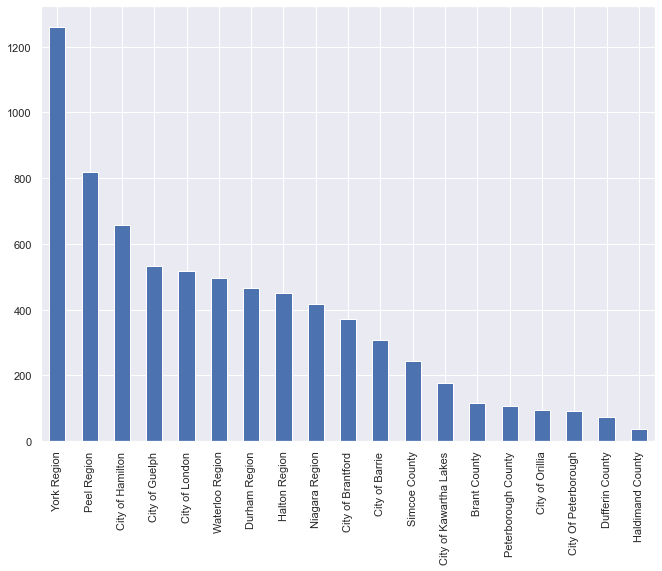

In [87]:
df.client_name.value_counts().plot.bar()

There are 19 clients included in the dataset. The client name will not be used as an input for NLP because the client name does not have any affect on the project name and project category.York Region has a good record of their public projects online.

### 1.1.2 Data Exploration - bid_type

There are a couple of bid types in the business of the public sector: Request for Tender(RFT), Request for Proposal(RFP), Request for Quotation(RFQ), Request for Information (RFI), and Request for Pre-Qualification(RFPQ).

In [88]:
df.bid_type.describe()

count     7246
unique      58
top        RFT
freq      1207
Name: bid_type, dtype: object

In [89]:
df.bid_type.unique().tolist()

['RFQ',
 'Tender',
 'RFP',
 'ITT',
 'RFSQ',
 'RFQ – High Score',
 'RFQ – Low Bid',
 'RFP – Consecutive Negotiation',
 'Non-Standard Procurement',
 'RFSQ – Prequalification',
 'Notice',
 'RFT',
 'RFQ (<)',
 'RFD (Disposal)',
 'RFPQ',
 'RFRC',
 'RFP - Revenue Generating',
 'RFP - Goods and Services',
 'RFP - Prime Consultant',
 'RFT - Construction - Stipulated Price - CCDC',
 'RFT - Public Works',
 'RFT - Construction - Unit Price',
 'RFT - Goods and Services',
 'RFT - Revenue Generating',
 'RFT - Vehicle',
 'Request For Quotation',
 'Request For Proposal',
 'Request For Supplier Qualification',
 'Request for Tender',
 'Request for Proposal',
 'Request for Qualifications',
 'Request for Quotation (Formal)',
 'Request for Information',
 'Informal Request for Quotation',
 'RFEOI',
 'Request for Supplier Pre-qualification',
 'Request For Quotations',
 'N',
 'NRFP',
 'Request For Tender',
 'Request For PreQualification',
 'Request for Proposal(N)',
 'DN',
 'VOR',
 'RFO',
 'Request for Offer'

In [90]:
df.bid_type.value_counts(dropna = False)

RFT                                             1207
Tender                                          1200
RFP                                             1188
Request for Tender                               671
RFQ                                              332
Request For Proposal                             295
Pre-Qualification                                223
Request For Quotation                            195
Request For Tender                               176
Request for Proposal                             176
RFT - Goods and Services                         157
RFT - Public Works                               152
RFPQ                                             123
RFP - Goods and Services                         104
RFQ – Low Bid                                    101
ITT                                               97
RFT - Construction - Stipulated Price - CCDC      91
Request for Quotation (Formal)                    85
RFP – Consecutive Negotiation                 

As we can see the bid types are not unified across different regions/cities, a hashmap is developed to revise values.

In [91]:
df.bid_type = df.bid_type.apply(lambda x : datacleaning.get_bidType(x))

In [92]:
df

,client_name,project_name,Category,bid_classification,bid_type,bid_ID,awarded_date,awarded_year,company_name
0,Brant County,"1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...",Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-07,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
1,Brant County,1 (One) Seven (7) Passenger Mini-Van,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-04,2021-03-26 0:00,2020,Oxford Dodge Chrysler (1992) LTD
2,Brant County,1 (One) Seven (7) Passenger Van / Wagon,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-10,2021-03-26 0:00,2020,East Court Ford Lincoln Oxford Dodge Chr...
3,Brant County,1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-08,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
4,Brant County,1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-09,2021-03-26 0:00,2020,East Court Ford Lincoln Finch Auto Group...
...,...,...,...,...,...,...,...,...,...
7241,York Region,York Telecom Network Construction And Maintena...,Construction - Fibre Optic Cable,Goods,Request for Tender(RFT),T-16-118,08-May,2017,Aecon Utilities Black & McDonald Limited...
7242,York Region,York-Durham Line Concrete Box Culvert Replacem...,NaN,Construction,Request for Tender(RFT),16-122,19-Aug,2016,Primrose Contracting (Ont.) Inc. Everstr...
7243,York Region,York-Peel 900Mm Twin Forcemains Combined Air R...,Construction - Water Wastewater Linear,Construction,Request for Tender(RFT),T-19-129,08-Jul,2020,H2Ontario Inc. Jeviso Construction Corpo...
7244,York Region,Yrt/Viva 2021-2025 Strategic Plan And 2017-202...,NaN,Services,Request for Proposal(RFP),P-15-189,24-May,2016,AECOM Canada Ltd. Dillon Consulting Limi...


### 1.1.3 Data Exploration - bid_classification

In [93]:
df.bid_classification.unique()

array(['Goods', 'Construction', 'Services'], dtype=object)

In [94]:
df.bid_classification.value_counts(dropna = False)

Services        3381
Construction    2672
Goods           1193
Name: bid_classification, dtype: int64

There are three type of bid classification: "Services", "Construction", and "Goods".

### 1.1.4 Data Exploration - bid_ID

In [95]:
df.bid_ID.value_counts().sort_values(ascending=False)

C12-06-18    39
17-151        3
17-126        3
19-181        2
17-142        2
             ..
P-15-189      1
T-19-80       1
T-17-02       1
T-16-132      1
P-16-161      1
Name: bid_ID, Length: 7138, dtype: int64

In [96]:
df.bid_ID.unique().size

7138

Note that there are bid that have duplicates IDs.

### 1.1.5 Data Exploration - Category
This is the target, "Category" had been manually added to the dataset for the model analysis.

In [97]:
df.Category.value_counts().sort_values(ascending=False)

Producer/Supplier                            862
Consulting - Water Wastewater Vertical       297
Construction - Water Wastewater Linear       209
Construction - Road                          207
Construction - Water Wastewater Vertical     203
Consulting - Transportation Road/Trainsit    201
Consulting - Geotechnical/Environmental      147
Consulting - Water Wastewater Linear          97
Construction - Facility                       88
Consulting - Facility                         85
Consulting - Others                           65
Construction - Landscaping                    63
Consulting - Transportation Bridge            30
Consulting - Software Services                17
Construction - Fibre Optic Cable              13
Consulting - Landscaping                       6
Consulting- Geotechnical/Environmental         1
Name: Category, dtype: int64

In [98]:
df.Category = df.Category.replace({'Consulting- Geotechnical/Environmental' : "Consulting - Geotechnical/Environmental"})
df.Category.value_counts().sort_values(ascending=False)

Producer/Supplier                            862
Consulting - Water Wastewater Vertical       297
Construction - Water Wastewater Linear       209
Construction - Road                          207
Construction - Water Wastewater Vertical     203
Consulting - Transportation Road/Trainsit    201
Consulting - Geotechnical/Environmental      148
Consulting - Water Wastewater Linear          97
Construction - Facility                       88
Consulting - Facility                         85
Consulting - Others                           65
Construction - Landscaping                    63
Consulting - Transportation Bridge            30
Consulting - Software Services                17
Construction - Fibre Optic Cable              13
Consulting - Landscaping                       6
Name: Category, dtype: int64

We only want to include the rows that contains "Category" in our dataset.

### 1.1.6 Remove Columns

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7246 entries, 0 to 7245
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   client_name         7246 non-null   object
 1   project_name        7246 non-null   object
 2   Category            2591 non-null   object
 3   bid_classification  7246 non-null   object
 4   bid_type            7246 non-null   object
 5   bid_ID              7246 non-null   object
 6   awarded_date        7246 non-null   object
 7   awarded_year        7246 non-null   int64 
 8   company_name        7246 non-null   object
dtypes: int64(1), object(8)
memory usage: 566.1+ KB


In [100]:
df.head(5)

,client_name,project_name,Category,bid_classification,bid_type,bid_ID,awarded_date,awarded_year,company_name
0,Brant County,"1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...",Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-07,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
1,Brant County,1 (One) Seven (7) Passenger Mini-Van,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-04,2021-03-26 0:00,2020,Oxford Dodge Chrysler (1992) LTD
2,Brant County,1 (One) Seven (7) Passenger Van / Wagon,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-10,2021-03-26 0:00,2020,East Court Ford Lincoln Oxford Dodge Chr...
3,Brant County,1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-08,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
4,Brant County,1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-09,2021-03-26 0:00,2020,East Court Ford Lincoln Finch Auto Group...


In [101]:
# columns to be removed, as they are not contribute to the category results
columns = ['client_name', 'bid_ID', 'awarded_date', 'awarded_year', 'bid_classification', 'company_name']
df = df.drop(columns=columns)

### 1.2 Data Cleaning

The category of the projects were manually added by me. We will ignore all the rows that missing category information.

In [102]:
df = df.dropna(subset=['Category'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2591 entries, 0 to 7245
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   project_name  2591 non-null   object
 1   Category      2591 non-null   object
 2   bid_type      2591 non-null   object
dtypes: object(3)
memory usage: 81.0+ KB


In [103]:
df.head()

,project_name,Category,bid_type
0,"1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...",Producer/Supplier,Request for Quotation(RFQ)
1,1 (One) Seven (7) Passenger Mini-Van,Producer/Supplier,Request for Quotation(RFQ)
2,1 (One) Seven (7) Passenger Van / Wagon,Producer/Supplier,Request for Quotation(RFQ)
3,1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck,Producer/Supplier,Request for Quotation(RFQ)
4,1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck,Producer/Supplier,Request for Quotation(RFQ)


#### 1.2.1 Category - Data Cleaning

Category is our target. We have 17 category of data. We have around 2500 data points for our study.It is likely that we may not have a good accuracy of the data based on the sample size. We want to think some strategies to shrink 17 category further down into boarder categories.

After some considerations, it is hard to to shrink down the categories, a soft shrink strategy is applied.

In [104]:
category_list = df.Category.unique().tolist()
category_list.sort()
category_list

['Construction - Facility',
 'Construction - Fibre Optic Cable',
 'Construction - Landscaping',
 'Construction - Road',
 'Construction - Water Wastewater Linear',
 'Construction - Water Wastewater Vertical',
 'Consulting - Facility',
 'Consulting - Geotechnical/Environmental',
 'Consulting - Landscaping',
 'Consulting - Others',
 'Consulting - Software Services',
 'Consulting - Transportation Bridge',
 'Consulting - Transportation Road/Trainsit',
 'Consulting - Water Wastewater Linear',
 'Consulting - Water Wastewater Vertical',
 'Producer/Supplier']

<AxesSubplot:>

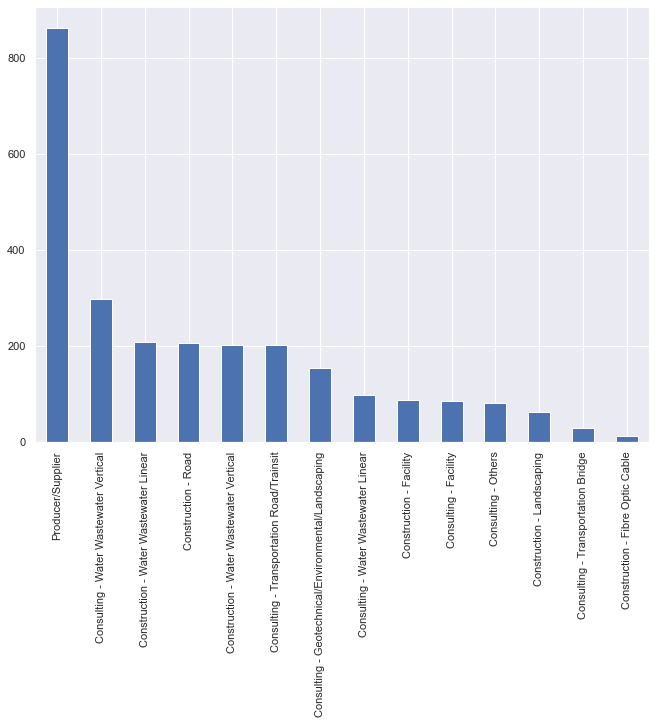

In [105]:
df.Category = df.Category.apply(lambda x : datacleaning.get_category(x))
df.Category.value_counts().plot.bar()

Note that we have lots of "Producer/Supplier", when we split the data, we have to make sure we this category will not affect the results due to large sample size - imbalanced data.

#### 1.2.1.1 Category - Assign Number

<AxesSubplot:>

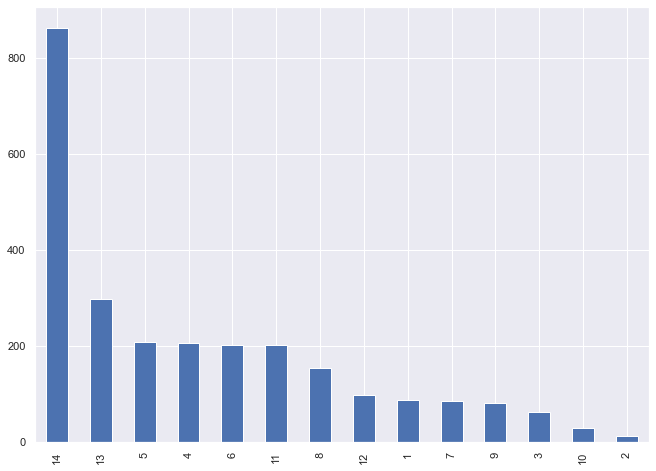

In [106]:
bid_category_numbering = {'Construction - Facility': 1,
                          'Construction - Fibre Optic Cable': 2,
                          'Construction - Landscaping': 3,
                          'Construction - Road': 4,
                          'Construction - Water Wastewater Linear': 5,
                          'Construction - Water Wastewater Vertical': 6,
                          'Consulting - Facility': 7,
                          'Consulting - Geotechnical/Environmental/Landscaping': 8,
                          'Consulting - Others': 9,
                          'Consulting - Transportation Bridge': 10,
                          'Consulting - Transportation Road/Trainsit': 11,
                          'Consulting - Water Wastewater Linear': 12,
                          'Consulting - Water Wastewater Vertical': 13,
                          'Producer/Supplier': 14
                          }
bid_category_numbering_reverse = {v: k for k, v in bid_category_numbering.items()}
df.Category = df.Category.apply(lambda x : bid_category_numbering.get(x))
df.Category.value_counts().plot.bar()

#### 1.2.2 bid_type - Data Cleaning

In [107]:
df.bid_type.value_counts()

Request for Tender(RFT)                1209
Request for Proposal(RFP)               799
Request for Pre-Qualification(RFPQ)     257
Request for Quotation(RFQ)              232
Request for Information (RFI)            52
Others                                   42
Name: bid_type, dtype: int64

Note that almost all type has "Request for". This is not useful too much in terms of determine what category the project should belong to. Hence, only the information the round bracket.
1. lower case the string
2. if the string contains "()", then only include the information in the ()

In [108]:
def bid_type_cleaning(data):
    data = data.lower()
    temp_string = ''
    if '(' in data:
        data_list = data.split('(')
        temp_string = data_list[1].strip()
        temp_string = temp_string.replace(')', '')
        data = temp_string
    
    return data

In [109]:
df.bid_type = df.bid_type.apply(lambda x : bid_type_cleaning(x))

In [110]:
df.bid_type.value_counts()

rft       1209
rfp        799
rfpq       257
rfq        232
rfi         52
others      42
Name: bid_type, dtype: int64

####  1.2.3 project_name - Data Cleaning

In [111]:
df.project_name.head(10)

0    1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...
1                 1 (One) Seven (7) Passenger Mini-Van
2              1 (One) Seven (7) Passenger Van / Wagon
3    1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck
4          1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck
5          1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck
6                   2 (Two) ¾ Ton 2Wd Cargo Style Vans
7                     2 Willow Street - Left Turn Lane
8                      2018 Detailed Condition Surveys
9                         2019 Poplar Hills Playground
Name: project_name, dtype: object

In [112]:
df.project_name[100:120]

220                           Agenda Management Software
222                               Alternative Fuel Study
223       Anne Street And Letitia Watermain Improvements
224    Anne Street/Highway 400 Watermain Crossing Aba...
225                   Annual Curb & Sidewalk Maintenance
226                Annual Groundwater Monitoring Program
228                          Asphalt Resurfacing Program
229        Asphalt, Curb And Sidewalk Maintenance - 2018
233    Bayfield Street Resurfacing From Cundles Road ...
234    Bayfield Street Water Tower - New Internal Lin...
235        Bcry Short Line Rail Market Feasibility Study
236                        Bell Farm Road Reconstruction
241                        Cipp Watermain Lining Program
245               City Wide Cycling Network Improvements
248    Community Energy And Greenhouse Gas Reduction ...
249              Comprehensive Transit Technology Review
252    Construction Inspection Services For Watermain...
254    Consulting Engineering S

Base on observation of the project's name, the follow data cleaning will be conducted:
1. lower case the entire string.
2. remove "()" and any content within them.
3. remove all punctuation marks (case: within in words, case: not included in words)

In [113]:
def project_name_cleaning(data):
    data = data.strip()
    data = data.lower()
    data = re.sub(r'[^a-zA-Z0-9\s]+', '', data)
    data = re.sub(' +', ' ', data)
    
    return data

df.project_name = df.project_name.apply(lambda x : project_name_cleaning(x))

In [114]:
df.project_name.head()

0    1 one 1 ton heavy duty 4wd cab and chassis tru...
1                      1 one seven 7 passenger minivan
2                    1 one seven 7 passenger van wagon
3        1 one ton 8 cyl standard cab 2wd pickup truck
4              1 one ton 4wd standard cab pickup truck
Name: project_name, dtype: object

In [115]:
df.project_name[100:120]

220                           agenda management software
222                               alternative fuel study
223       anne street and letitia watermain improvements
224    anne streethighway 400 watermain crossing aban...
225                     annual curb sidewalk maintenance
226                annual groundwater monitoring program
228                          asphalt resurfacing program
229           asphalt curb and sidewalk maintenance 2018
233    bayfield street resurfacing from cundles road ...
234    bayfield street water tower new internal liner...
235        bcry short line rail market feasibility study
236                        bell farm road reconstruction
241                        cipp watermain lining program
245               city wide cycling network improvements
248    community energy and greenhouse gas reduction ...
249              comprehensive transit technology review
252    construction inspection services for watermain...
254    consulting engineering s

### 2.0 Exploratory Data Analysis

#### 2.1.1 Character Counts

<AxesSubplot:>

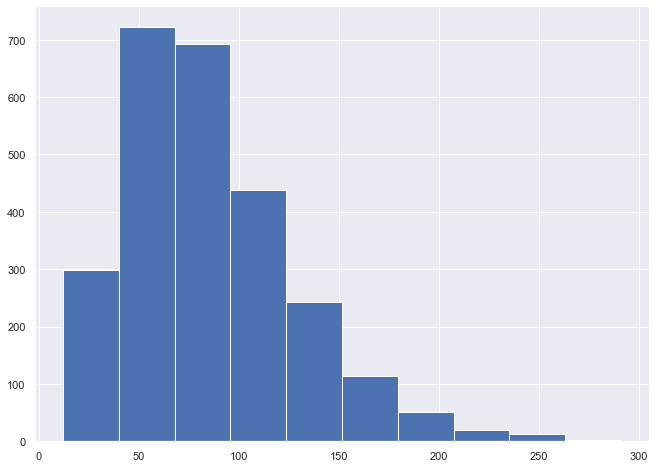

In [116]:
df.project_name.str.len().hist()

The histogram shows that the project name headlines range from 20 - 290. Generally, it is between 50 - 100 characters.

#### 2.1.2 Words Counts

<AxesSubplot:>

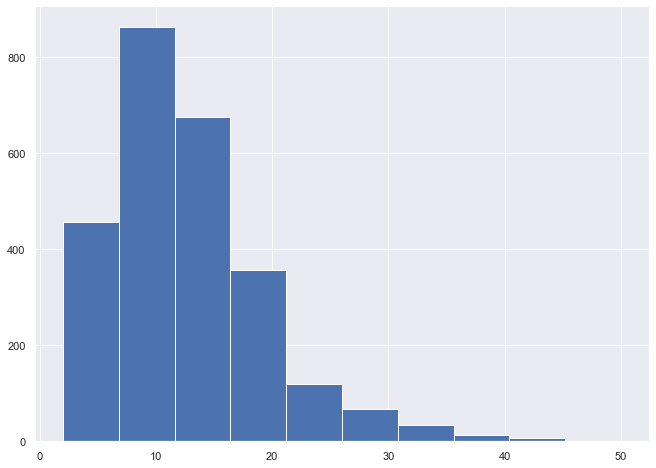

In [117]:
df.project_name.str.split().map(lambda x: len(x)).hist()

It is interesting to see that generally the words in the project name range from 2 to 20, but there are projects with longer names.

#### 2.1.3 Average Words Length

<AxesSubplot:>

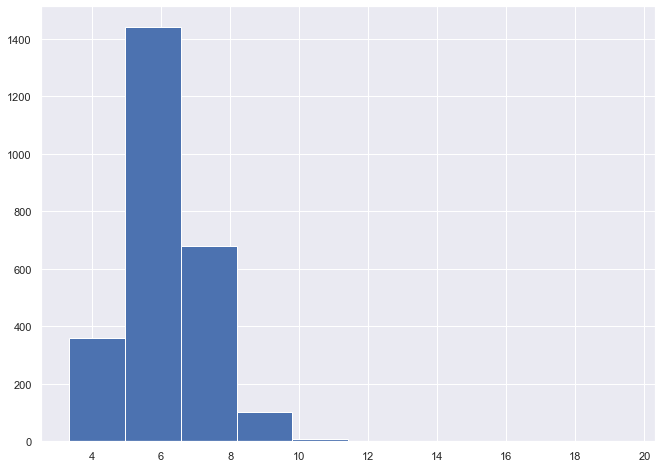

In [118]:
df.project_name.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

#### 2.1.4 Most Frequent words - Stopwords

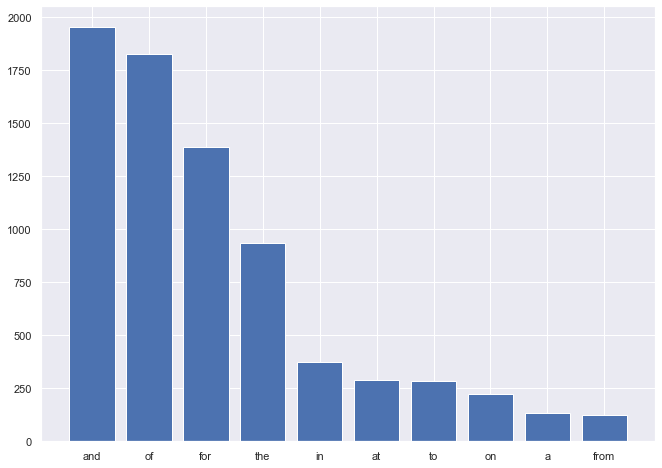

In [119]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    project = text.str.split()
    project = project.values.tolist()
    corpus = [word for i in project for word in i]
    from collections import defaultdict
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
plot_top_stopwords_barchart(df.project_name)

#### 2.1.5 Most Frequent words - Counter Words

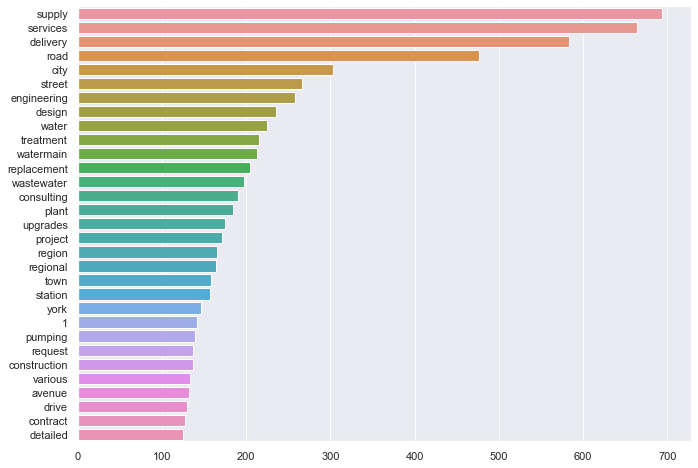

In [120]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    sns.set(rc={'figure.figsize':(11,8)})
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)


plot_top_non_stopwords_barchart(df.project_name)

#### 2.1.6 Bigrams

In [121]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

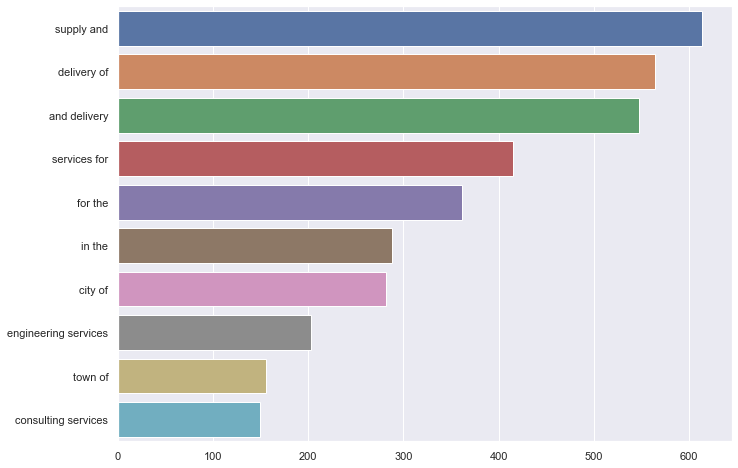

In [122]:
plot_top_ngrams_barchart(df.project_name,2)

#### 2.1.6 Tri-grams

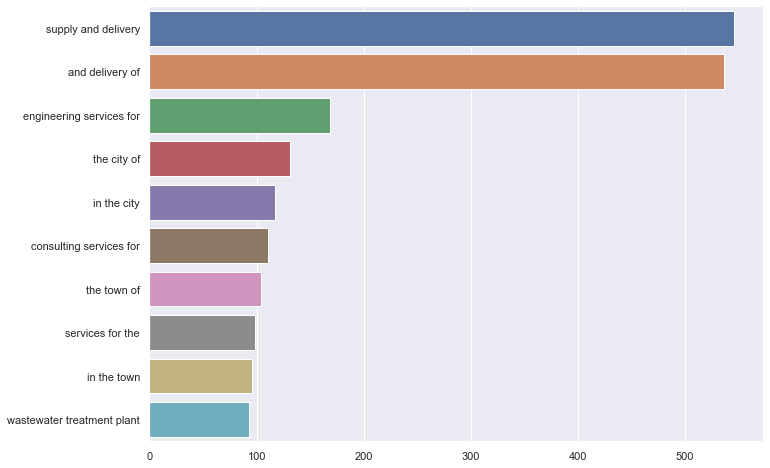

In [123]:
plot_top_ngrams_barchart(df.project_name,3)

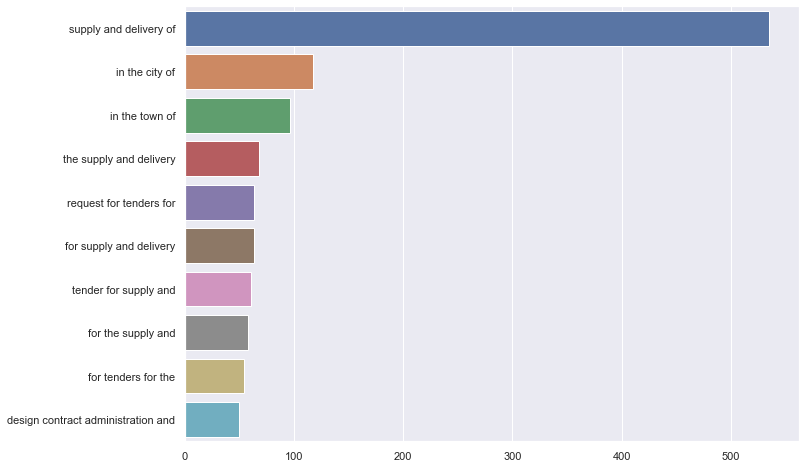

In [124]:
plot_top_ngrams_barchart(df.project_name,4)

### 2.2.1 Wordcloud - Overall

In [125]:
def plot_wordcloud(text):
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        colormap="Dark2",
        stopwords=set(STOPWORDS),
        max_words=50,
        max_font_size=50, 
        scale=5,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

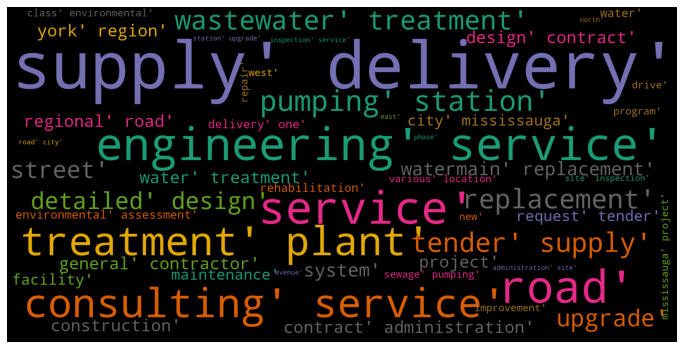

In [126]:
plot_wordcloud(df.project_name)

### 2.2.2 Wordcloud by Category

Producer/Supplier


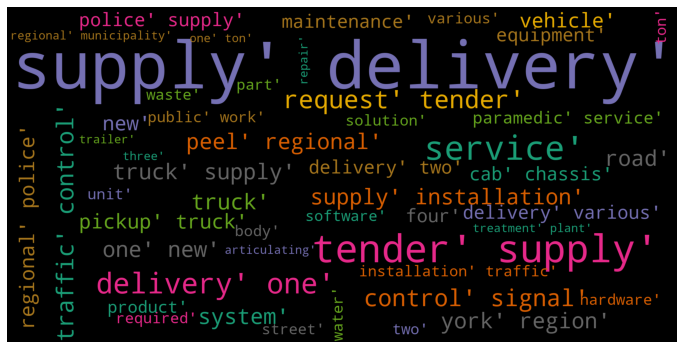

Construction - Road


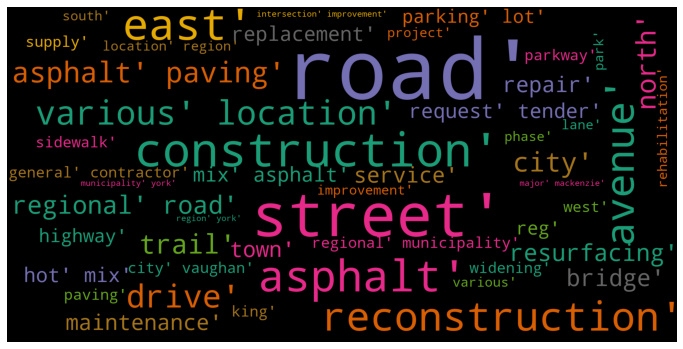

Consulting - Transportation Bridge


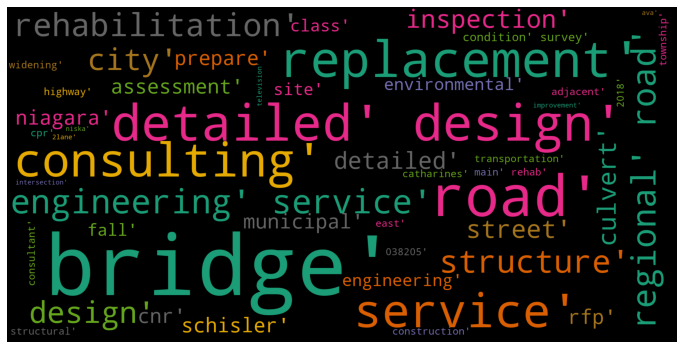

Construction - Landscaping


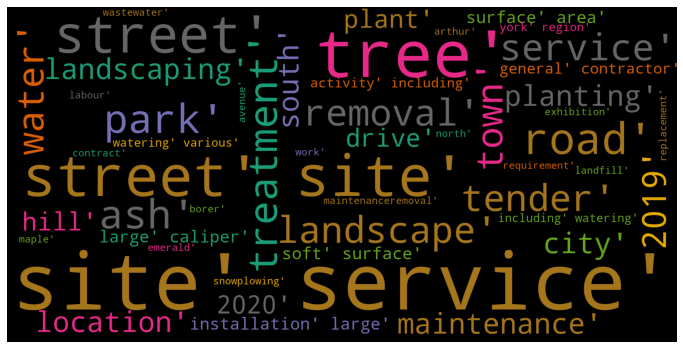

Construction - Water Wastewater Linear


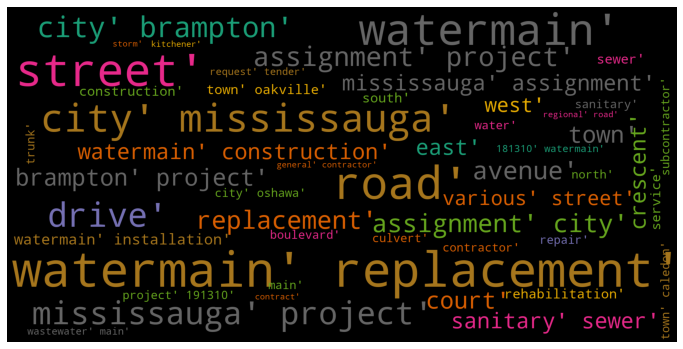

Consulting - Facility


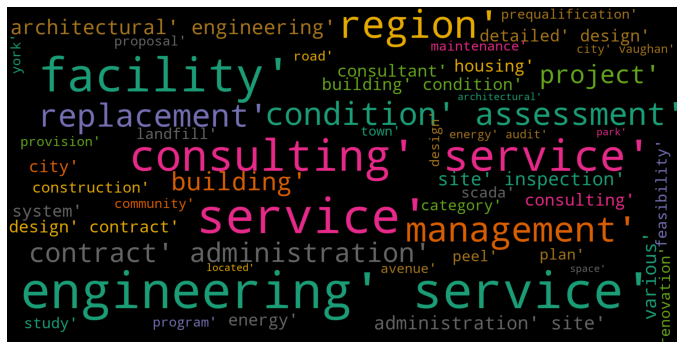

Consulting - Water Wastewater Linear


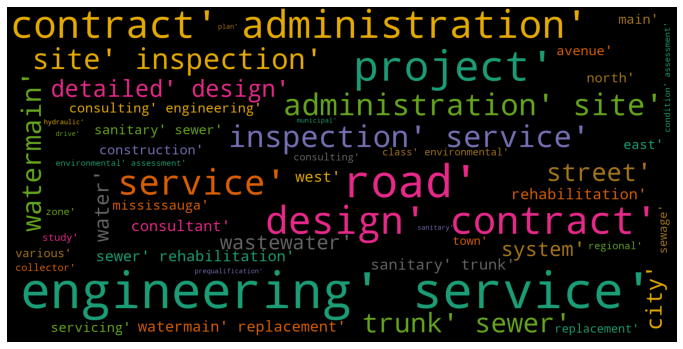

Consulting - Geotechnical/Environmental/Landscaping


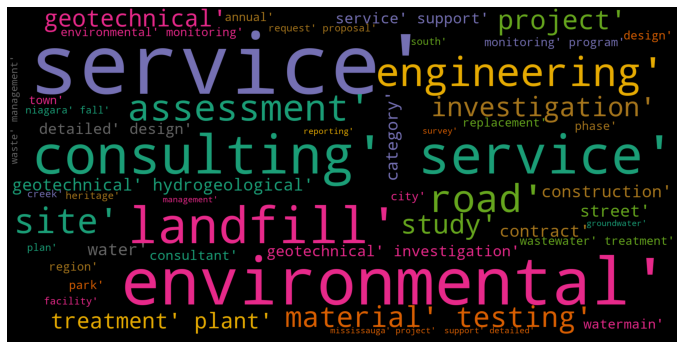

Construction - Water Wastewater Vertical


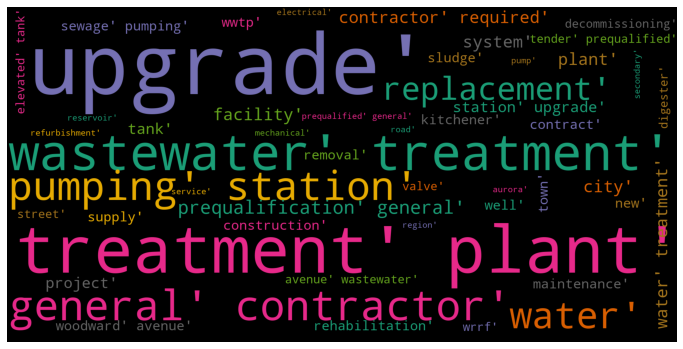

Consulting - Others


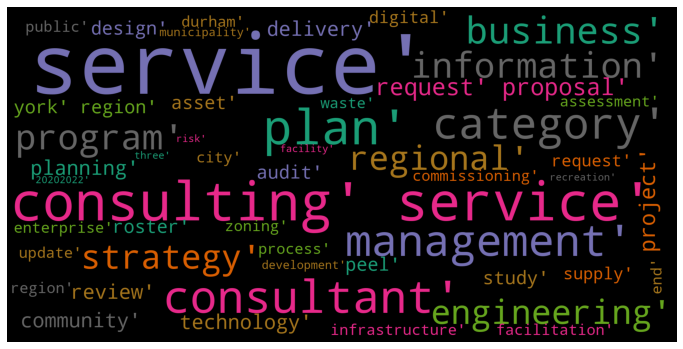

Consulting - Transportation Road/Trainsit


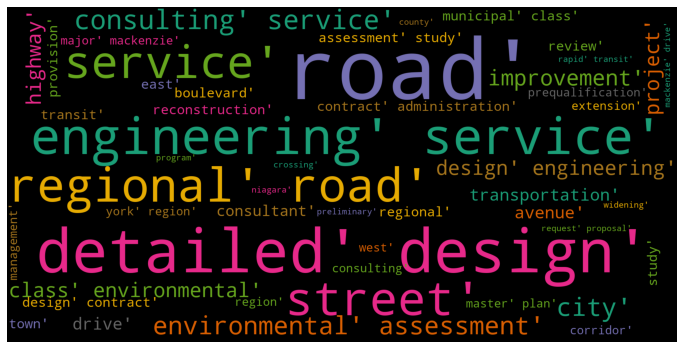

Consulting - Water Wastewater Vertical


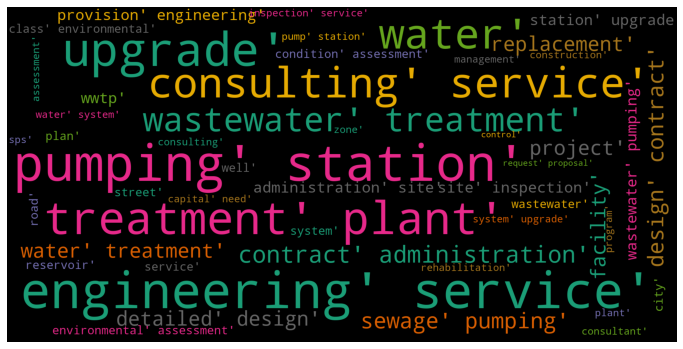

Construction - Facility


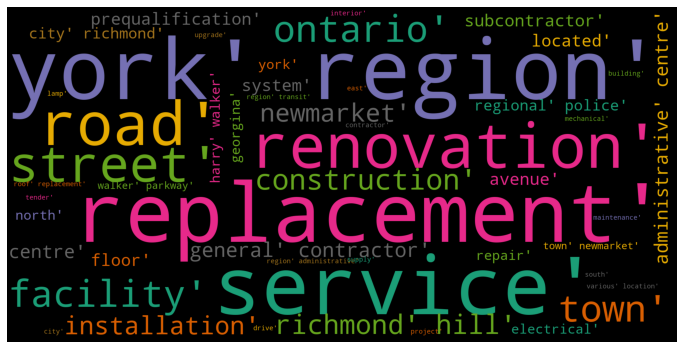

Construction - Fibre Optic Cable


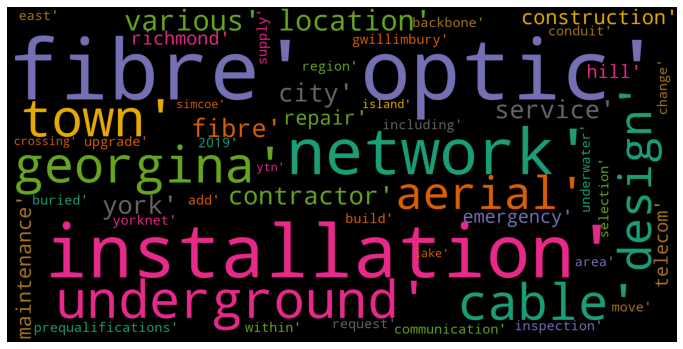

In [130]:
category_list = df.Category.unique().tolist()

# create a dict of list and pandas frames
dict_category = {}

for item in category_list:
    dict_category[item] = df[df.Category == item].project_name

for key, df_project in dict_category.items():
    print(bid_category_numbering_reverse.get(key))
    plot_wordcloud(df_project)